# Análisis Exploratorio inicial

Exploración de las primeras tres preguntas del proyecto de pronóstico de demanda usando únicamente `pandas` y `matplotlib`.


In [235]:

import pandas as pd 
import matplotlib.pyplot as plt

CSV ="ventas_hiperrealistas.csv"

meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

#recorre la lista meses asociando un indice (Ene = 1), en donde label es el mes e idx el numero asociado
NumeroMes = {idx + 1: label for idx, label in enumerate(meses)} 
#trabajaremos con series temporales históricas para extraer tendencias y estacionalidad antes de modelar.


In [236]:
df = pd.read_csv(CSV, parse_dates=["Date"])


columnas = df.columns.tolist() #lista con los encabezados
rango = (df["Date"].min().date(), df["Date"].max().date())
print(f"Primer y último registro: {rango[0]} a {rango[1]}")
#Primeras 5 filas
print("primeras 5 filas")
df.head()


Primer y último registro: 2012-01-01 a 2020-12-31
primeras 5 filas


,TransactionID,Date,ProductID,ProductName,ProductCategory,Quantity,UnitPrice,TotalPrice
0,1,2012-01-01,402,Leche Entera 1L,Lácteos,2,950,1900
1,2,2012-01-01,103,Pan de Molde Blanco,Panadería,1,1800,1800
2,3,2012-01-01,101,Refresco Cola 2L,Bebidas,2,1500,3000
3,4,2012-01-01,402,Leche Entera 1L,Lácteos,1,950,950
4,5,2012-01-01,401,Yogurt Frutilla 125g,Lácteos,3,400,1200


## Preguntas


## 1. Análisis Exploratorio y Visualización (15 Puntos)


1. Visión Agregada (5 Puntos): Genere un gráfico de series de tiempo que muestre la evolución de la Cantidad total vendida (sumando todos los productos) a lo largo del tiempo. Comente la tendencia general y cualquier patrón cíclico o estacional que observe a nivel macro.

En esta sección, quisimos aplicar además el método de medias moíviles para poder visualizar de una froma alisada el comportamiento de los datos y así detectar de mejor medida patrones cíclicos y/o estacionales

Resumen de la serie diaria (unidades):
  Inicio operaciones: 2012-01-01
  Final de operaciones: 2020-12-31
  Promedio diario (unidades): 479.0
  Máximo diario (unidades): 2085
  Mínimo diario (unidades): 134


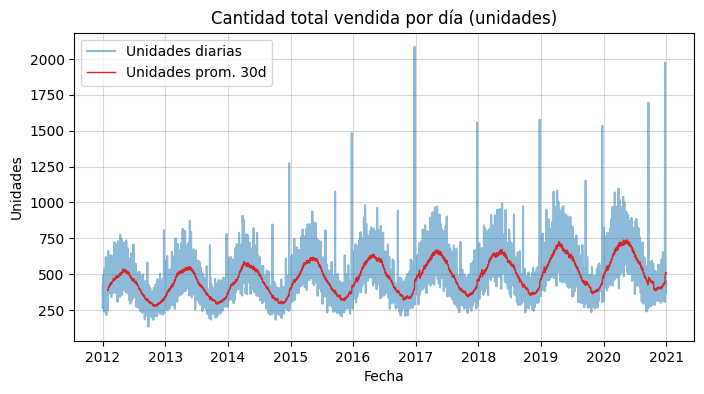

In [237]:

# Series de tiempo: agregamos transacciones a nivel diario (unidades y ventas).

#ordenasmos las ventas diarias, agrupando por fecha y suma de las cantidades vendidas en esa fecha
ventas_diarias = (
    df.groupby('Date')
      .agg(TotalUnidadesDia=('Quantity', 'sum'))
      .reset_index()
      .sort_values('Date')
)

# Medias móviles de 30 días en unidades y ventas
#PU30: Promedio unidades a 30 dias
#PV30: Promedio Ventas a 30 dias
ventas_diarias['PU30'] = ventas_diarias['TotalUnidadesDia'].rolling(window=30, min_periods=30).mean().shift(1)


#Resumen a grandes rasgos del CSV

resumen_unidades = {
    'Inicio operaciones': ventas_diarias['Date'].min().date(),
    'Final de operaciones': ventas_diarias['Date'].max().date(),
    'Promedio diario (unidades)': round(ventas_diarias['TotalUnidadesDia'].mean(), 0),
    'Máximo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].max()),
    'Mínimo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].min()),
}

print('Resumen de la serie diaria (unidades):')
for i, valor in resumen_unidades.items():
    print(f'  {i}: {valor}')

#Grafica Serie de tiempo con método medias moviles a 30 dias
#Unidades vendidas
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PU30'], label='Unidades prom. 30d', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por día (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/2506886598.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Date", freq="M"))


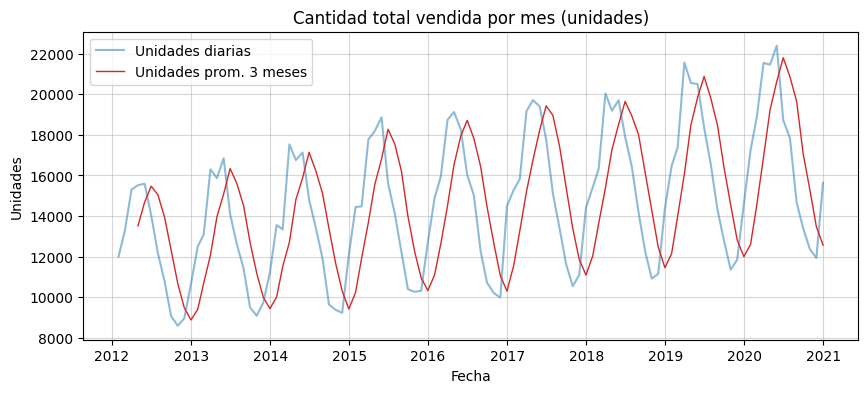

In [238]:
#Gráfico del mes a mes
ventas_mensuales = (
    df.groupby(pd.Grouper(key="Date", freq="M"))
      .agg(TotalUnidadesDia=('Quantity', 'sum'),
           TotalVentasDia=('TotalPrice', 'sum'))
      .reset_index()
      .sort_values('Date')
)
#media movil a 3 meses
ventas_mensuales['PU3'] = ventas_mensuales['TotalUnidadesDia'].rolling(window=3, min_periods=3).mean().shift(1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ventas_mensuales['Date'], ventas_mensuales['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_mensuales['Date'], ventas_mensuales['PU3'], label='Unidades prom. 3 meses', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por mes (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

Como podemos observar en los graficos, existe precencia de estacionalidad, en donde a nivel anual presentamos el mismo comportamiento en que las ventas suben significativamente hasta una fecha en particular y luego bajan con el mismo o muy similar grado.

2.  Dinámica de Productos (5 Puntos): Cree un único gráfico que muestre las series de tiempo de la Cantidad vendida para la “Leche Entera 1L” y el “Helado Chocolate Suizo 1L”. Compare y contraste visualmente los patrones de demanda de ambos. ¿Son sus tendencias y volatilidades similares?

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/4031711139.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='Date', freq='M'), 'ProductName'])['Quantity']


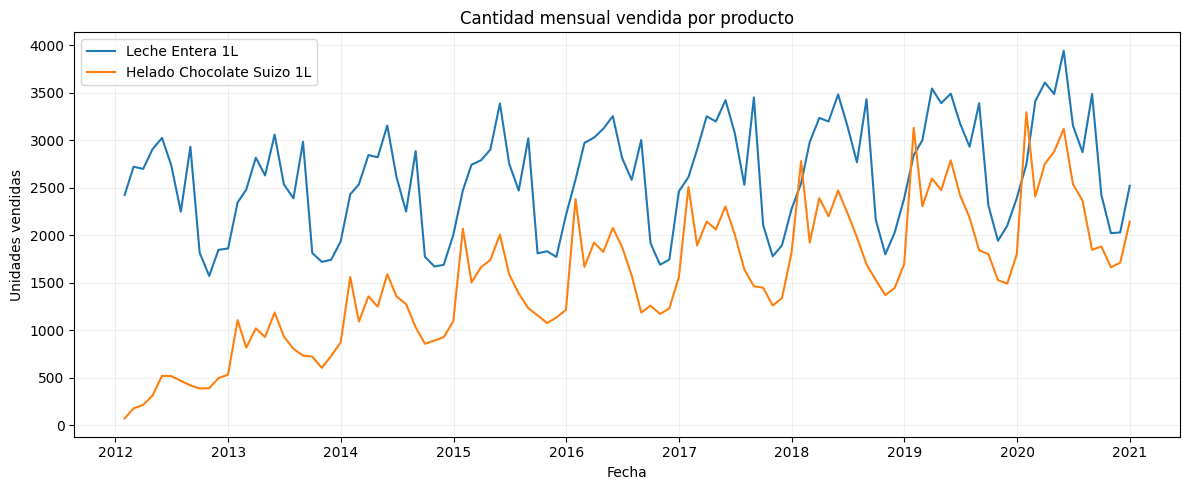

In [239]:
productos= ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
serie_productos = (
    df[df['ProductName'].isin(productos)]
    .groupby([pd.Grouper(key='Date', freq='M'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
    .sort_values('Date')
)

helado = serie_productos[serie_productos['ProductName'] == 'Helado Chocolate Suizo 1L']
leche = serie_productos[serie_productos['ProductName'] == 'Leche Entera 1L']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(leche['Date'], leche['Quantity'], label='Leche Entera 1L')
ax.plot(helado['Date'], helado['Quantity'], label='Helado Chocolate Suizo 1L')

ax.set_title('Cantidad mensual vendida por producto')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades vendidas')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()


Conclusiones:
Las ventas de leche mantienen volumenes altos y relativamente estables, en donde, si vemos de forma anual, esta suele tener 2 peaks por año, pero en promedio, una gran oscilación anual, popr lo que podemos decir que hay estacionalidad, ahora, esta estacionalidad parece ser aditiva, ya que la amplitud de las oscilaciones no se ve a simple vista un crecimiento significativo año a año. Luego, no se aprecian efectos de tendencia, esta es casi despreciable (constante).

En cuanto a las ventas de helado, podemos ver claramente efectos de tendecia, en donde a comienzos de 2012 posee una demanda baja y a medida que pasan los años, esta demanda va aumentando en promedio de manera aditiva. En cuanto a la estacionalidad, podiramos decir ue lleva una de forma multiplicatica, ya que año a año, posee oscilaciones con una amplitud mayor con el paso del tiempo. Estas oscilaciones parecen tener una correlacion negativa con respecto a las de la leche, pues, cuando la leche alcanza un peak, el helado alcanza un valle.

En cuanto a volatilidad, aparentemente el helado es más volatil, debido a su incremento en los ultimos años y que los peaks y valles de este, se forman de manera más abrupa a comparación de la Leche


3. Análisis de Estacionalidad (5 Puntos): Mediante gráficos de cajas (boxplots), ana- lice la distribución mensual de las ventas para la leche y el helado. ¿Qué meses presentan mayor y menor demanda para cada uno? ¿Confirman los gráficos la hipótesis de que el helado es un producto estacional y la leche es estable?

Leche Entera 1L: mayor mediana en Mayo (3387 unidades), menor en Octubre (1778 unidades)
Helado Chocolate Suizo 1L: mayor mediana en Enero (2380 unidades), menor en Octubre (1171 unidades)


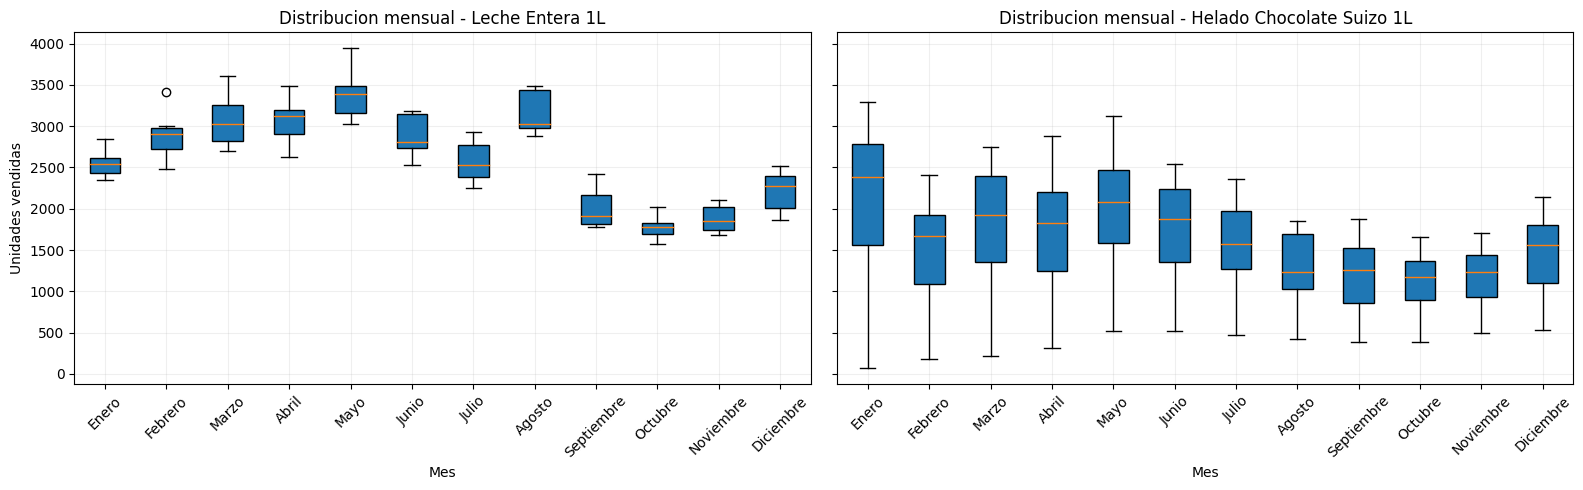

In [240]:

ventas_mensuales_productos= (
    df[df['ProductName'].isin(productos)]
    .groupby([pd.Grouper(key='Date', freq='MS'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
)

ventas_mensuales_productos['NroMes'] = ventas_mensuales_productos['Date'].dt.month
meses= ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
ventas_mensuales_productos['MesNombre'] = ''
for i, mes in enumerate(meses, start=1):
    filas_mes = ventas_mensuales_productos['NroMes'] == i
    if filas_mes.any():
        ventas_mensuales_productos.loc[filas_mes, 'MesNombre'] = mes

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for ax, producto in zip(axes, productos):
    datos_producto = ventas_mensuales_productos[ventas_mensuales_productos['ProductName'] == producto]
    datos_por_mes = [
        datos_producto.loc[datos_producto['MesNombre'] == mes, 'Quantity'].values
        for mes in meses
    ]
    ax.boxplot(datos_por_mes, labels=meses, patch_artist=True)
    ax.set_title(f'Distribucion mensual - {producto}')
    ax.set_xlabel('Mes')
    if ax is axes[0]:
        ax.set_ylabel('Unidades vendidas')
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout()

resumen_medianas = (
    ventas_mensuales_productos
    .groupby(['ProductName', 'MesNombre'])['Quantity']
    .median()
    .unstack()
    .reindex(columns=meses)
)
for producto in productos:
    serie = resumen_medianas.loc[producto]
    mes_max = serie.idxmax()
    mes_min = serie.idxmin()
    print(f"{producto}: mayor mediana en {mes_max} ({serie.max():.0f} unidades), menor en {mes_min} ({serie.min():.0f} unidades)")



Conclusiones:
Como podemos ver, en el boxplot de la leche, se observa una disperción poco variable,  las cajas más comprimidas significa que posee ventas más estables, las medianas dicen además que sus ventas suben hasta mediado de año y luego vuelven a bajar.

En cuanto al helado Las cajas son más altas y los bigotes más largos Por lo que existe una gran variabilidad de sus ventas, además los "bigotes" largos que posee implica ventas irregulares y sensibles a factores externos, como es de esperar de un producto como el helado.

Los graficos respaldan que el helado es altamente estacional mientras la leche presenta demanda mas estable y predecible.

## 2. Preparación de Datos


1. Agregación Temporal (3 Puntos): Agregue los datos a una frecuencia temporal regular (diaria, semanal o mensual). Justifique la elección de la frecuencia, considerando el balance entre granularidad y interpretabilidad para productos de retail.


In [241]:
#Dado que en el siguiente item, en donde armamos el modelo, 
# trabajaremos solo con el producto Leche Entera 1L, extraeremos solo la info de ese producto
ventas_leche_semanal = (
    df[df['ProductName'] == "Leche Entera 1L"]
    .set_index('Date')[['Quantity', 'TotalPrice']]
    .resample("W") #frecuencia semanal para entrenar al modelo
    .sum()
    
    .reset_index()
)

print("Ventas de Leche entera primeras 5 semanas:")
print(ventas_leche_semanal.head())

Ventas de Leche entera primeras 5 semanas:
        Date  Quantity  TotalPrice
0 2012-01-01       102       96900
1 2012-01-08       567      538650
2 2012-01-15       526      499700
3 2012-01-22       603      572850
4 2012-01-29       501      475950


Hasta ahora habiamos trabajado de manera mensual para la visualización exploratia de datos, esto ayudó a visualizar con poco ruido la información y hacer analisis sencillos. De todas formas, para preparar los datos decidimos trabajar de forma semanal para conservar el patrón estacional eliminando el ruido que ocasiona verlo de forma diaria, pero tambien para tener suficiente información mensual para trabjar, ya que como en el caso del helado, este poseía ventas muy fuertes durante verano, por lo cual enconrtramos importante mantener de forma más detallada las ventas dentro de cada mes para poder entrenar posteriormente el modelo.

Por otro lado, si utilizamos datos mensuales, tendriamos pocos datos para entrenar el modelo, por lo que creemos qeu el equilibrio está en utilizar un dataset con datos semanales.


2. División de Muestras (2 Puntos): Segmente su serie de tiempo en un conjunto de entrenamiento (primer 80 % de los datos) y uno de prueba (20 % final). Explique por qué esta división es fundamental para una evaluación objetiva del rendimiento del modelo.

In [242]:
cant_registros_sem = len(ventas_leche_semanal)
cant_train_sem = int(cant_registros_sem * 0.8)
ventas_train_sem = ventas_leche_semanal.iloc[:cant_train_sem].copy()
ventas_test_sem = ventas_leche_semanal.iloc[cant_train_sem:].copy()

print(f"En nuestro dataset, tenemos {cant_registros_sem} registros")
print(f"Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir {cant_train_sem} datos")
print(f"El resto será de prueba, es decir {cant_registros_sem - cant_train_sem} datos (último 20%)")

En nuestro dataset, tenemos 471 registros
Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir 376 datos
El resto será de prueba, es decir 95 datos (último 20%)


Utilizar el 80% de los datos para entrenar el modelo permitirá que este tenga una gran cantidad de información para entender el comportamiento de las ventas. Luego, es necesario dejar un porcentaje restante para poder probar el modelo a ver si este logra predecir los datos reales y poder obtener métricas de accuracy para entender qué tanto acierta el modelo.


Same as last two codes but in terms of months

In [243]:
#Dado que en el siguiente item, en donde armamos el modelo, 
# trabajaremos solo con el producto Leche Entera 1L, extraeremos solo la info de ese producto
ventas_leche_mensual = (
    df[df['ProductName'] == "Leche Entera 1L"]
    .set_index('Date')[['Quantity', 'TotalPrice']]
    .resample("M") #frecuencia semanal para entrenar al modelo
    .sum()
    
    .reset_index()
)

print("Ventas de Leche entera primeros 5 meses:")
print(ventas_leche_mensual.head())

Ventas de Leche entera primeros 5 meses:
        Date  Quantity  TotalPrice
0 2012-01-31      2424     2302800
1 2012-02-29      2721     2584950
2 2012-03-31      2698     2563100
3 2012-04-30      2904     2758800
4 2012-05-31      3024     2872800


/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/2487885431.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M") #frecuencia semanal para entrenar al modelo


In [244]:
cant_registros_mes = len(ventas_leche_mensual)
cant_train_mes = int(cant_registros_mes * 0.8)
ventas_train_mes = ventas_leche_mensual.iloc[:cant_train_mes].copy()
ventas_test_mes = ventas_leche_mensual.iloc[cant_train_mes:].copy()

print(f"En nuestro dataset, tenemos {cant_registros_mes} registros")
print(f"Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir {cant_train_mes} datos")
print(f"El resto será de prueba, es decir {cant_registros_mes - cant_train_mes} datos (último 20%)")

En nuestro dataset, tenemos 108 registros
Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir 86 datos
El resto será de prueba, es decir 22 datos (último 20%)


## 3. Modelamiento y Pronóstico (25 Puntos)

1. Justificación del Modelo (5 Puntos): Describa el modelo de pronóstico que ha elegido. Basándose en los hallazgos del análisis exploratorio (tendencia, estacionalidad), explique por qué este modelo es adecuado para el producto seleccionado. Explique cómo determinó los parámetros clave del modelo.

La leche: El modelo Holt-Winters (alisado exponencial triple aditivo) se justifica porque la serie presenta un patrón estacional claramente repetitivo. Este método permite modelar la estacionalidad y la variabilidad, a diferencia de los dempas modelos vistos que no tienen una componente de estacionalidad. Además, como vimos, las ventas de leche poseen una clara estacionalidad que podrian modelarse de mehor manera con el alisado exponensial triple que con otro método visto

2. Implementación y Entrenamiento (8 Puntos): Implemente el modelo elegido en Python, R o Excel. Entrene el modelo utilizando exclusivamente el conjunto de datos de entrenamiento.

# Primero Modelo basado sobre los datos en meses

In [245]:
#libraries
#pip install statsmodels
#pip install scikit-learn
#!pip install seaborn

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [246]:
#We first create two new data frames that can be used by our Holt-Winters model. These dataframe are composed of only the date (by month) and the quantity attributes 

y_train_mes = ventas_train_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
y_test_mes  = ventas_test_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/1762201556.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_train_mes = ventas_train_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/1762201556.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_test_mes  = ventas_test_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)


As mentioned earlier, the model we will be investigating is the Holt-Winters model, also known as additive triple exponential smoothing. We will test this model under several different configurations to determine which one best fits the data. From the previous graphs, we assume that the additive model performs better than the multiplicative one for the milk sales. In terms of trend, we can observe a slight upward movement, but we will still test both versions—with and without an additive trend. The other parameter we will compare is the aggregation level of the data (monthly versus weekly). Since we are varying two binary parameters (trend type and aggregation), this results in four models to compare.

To construct the Holt-Winters model, we first need to compute the seasonal parameters ct for the first cycle of data, that is, the first year. This is done by dividing the sales of each specific month or week by the annual average. Using these parameters, we can then estimate the level parameters St	​

 for the following periods by dividing the sales by the corresponding seasonal parameter ct  from the same month or week of the previous cycle. The trend parameter can be estimated by subtracting the ratios between sales and seasonal parameters of two different periods, for example between period 12 and period 1. After these initial estimates, the parameters for subsequent periods are computed using the Holt-Winters equations and initial values for the smoothing coefficients 𝛼,𝛽, and γ. Typical starting values might be (0.1, 0.1, 0.1) or (0.2, 0.1, 0.1). The goal of the model is to optimize these parameters in order to minimize forecasting errors. This is precisely what happens when using the function ExponentialSmoothing(...).

The ExponentialSmoothing function in Python, from the statsmodels library, is used to build a Holt-Winters or ETS model that captures level, trend, and seasonality in a time series. When called with parameters such as trend, seasonal, and seasonal_periods, it defines the structure of the model. The function estimates several unknown quantities: the smoothing coefficients alpha, beta, and gamma, which determine how strongly new observations influence the estimated level, trend, and seasonal components, as well as the initial states such as the first level, trend, and seasonal cycle. Once fitted, the model produces both fitted values and forecasts for future periods.

When the argument optimized=True is used, the function automatically selects the values of alpha, beta, and gamma (and the initial states) that minimize the sum of squared one-step-ahead forecast errors, known as the SSE (Sum of Squared Errors). Mathematically, the function minimizes
SSE(θ) = Σ (y_t − ŷ_t|t−1(θ))²,
where θ represents all the model parameters. The optimization typically combines a coarse grid search (if use_brute=True) to find good starting points, followed by a local numerical optimization method such as L-BFGS-B that refines the parameters within valid bounds between 0 and 1.

Minimizing SSE is equivalent to minimizing the mean squared error (MSE) or the root mean squared error (RMSE), since these measures differ only by a constant scaling factor or a square root. For a fixed number of observations n,
MSE = SSE / n and RMSE = √(SSE / n).
Therefore, the parameter values that minimize SSE also minimize RMSE. In other words, the model is tuned so that the square of its forecast errors is as small as possible, and the RMSE that we later compute from the predictions is simply a rescaled version of the same objective function.

Español tradución

Como se mencionó anteriormente, el modelo que investigaremos es el modelo de Holt-Winters, también conocido como alisado exponencial triple aditivo. Probaremos este modelo bajo varias configuraciones diferentes para determinar cuál se ajusta mejor a los datos. A partir de los gráficos anteriores, suponemos que el modelo aditivo funciona mejor que el multiplicativo para las ventas de leche. En cuanto a la tendencia, se puede observar un leve movimiento ascendente, pero igualmente probaremos ambas versiones, con y sin tendencia aditiva. El otro parámetro que compararemos es el nivel de agregación de los datos (mensual frente a semanal). Dado que variamos dos parámetros binarios (tipo de tendencia y nivel de agregación), esto da lugar a cuatro modelos para comparar.

Para construir el modelo de Holt-Winters, primero necesitamos calcular los parámetros estacionales 𝑐𝑡 para el primer ciclo de datos, es decir, el primer año. Esto se hace dividiendo las ventas de cada mes o semana por el promedio anual. A partir de estos parámetros, se pueden estimar los parámetros de nivel 𝑆𝑡 para los períodos siguientes dividiendo las ventas por el parámetro estacional correspondiente 𝑐𝑡 del mismo mes o semana del ciclo anterior. El parámetro de tendencia puede estimarse restando las razones entre las ventas y los parámetros estacionales de dos períodos diferentes, por ejemplo entre el período 12 y el período 1. Después de estas estimaciones iniciales, los parámetros de los períodos siguientes se calculan utilizando las ecuaciones de Holt-Winters y valores iniciales para los coeficientes de suavizado 𝛼, 𝛽 y γ. Los valores iniciales típicos pueden ser (0.1, 0.1, 0.1) o (0.2, 0.1, 0.1). El objetivo del modelo es optimizar estos parámetros para minimizar los errores de predicción. Esto es precisamente lo que ocurre al usar la función ExponentialSmoothing(...).

La función ExponentialSmoothing en Python, de la biblioteca statsmodels, se utiliza para construir un modelo de Holt-Winters o ETS que capta el nivel, la tendencia y la estacionalidad de una serie temporal. Al llamarla con parámetros como trend, seasonal y seasonal_periods, se define la estructura del modelo. La función estima varias cantidades desconocidas: los coeficientes de suavizado alfa, beta y gamma, que determinan cuánto influyen las nuevas observaciones en el nivel, la tendencia y los componentes estacionales estimados, así como los estados iniciales como el primer nivel, la primera tendencia y el primer ciclo estacional. Una vez ajustado, el modelo produce tanto valores ajustados para el período observado como pronósticos para períodos futuros.

Cuando se usa el argumento optimized=True, la función selecciona automáticamente los valores de alfa, beta y gamma (y los estados iniciales) que minimizan la suma de los errores cuadráticos de un paso hacia adelante, conocida como SSE (Sum of Squared Errors). Matemáticamente, la función minimiza
SSE(θ) = Σ (y_t − ŷ_t|t−1(θ))²,
donde θ representa todos los parámetros del modelo. La optimización combina normalmente una búsqueda en cuadrícula gruesa (si use_brute=True) para encontrar buenos puntos de partida, seguida de un método de optimización numérica local como L-BFGS-B, que refina los parámetros dentro de límites válidos entre 0 y 1.

Minimizar la SSE es equivalente a minimizar el error cuadrático medio (MSE) o la raíz del error cuadrático medio (RMSE), ya que estas medidas difieren solo por un factor constante o una raíz cuadrada. Para un número fijo de observaciones n,
MSE = SSE / n y RMSE = √(SSE / n).
Por lo tanto, los valores de los parámetros que minimizan la SSE también minimizan el RMSE. En otras palabras, el modelo se ajusta de modo que el cuadrado de sus errores de predicción sea lo más pequeño posible, y el RMSE que luego calculamos a partir de las predicciones es simplemente una versión reescalada de la misma función objetivo.

In [247]:
Model1 = ExponentialSmoothing(
    y_train_mes,
    trend="add",             # set to None if no trend
    seasonal="add",          # use "mul" if seasonality scales with level
    seasonal_periods=12
).fit(optimized=True, use_brute=True)  # brute grid first helps avoid local minima

print("Parámetros ajustados:", Model1.params)

Parámetros ajustados: {'smoothing_level': 0.10862951192570565, 'smoothing_trend': 0.09455970037301735, 'smoothing_seasonal': 0.06972491618701367, 'damping_trend': nan, 'initial_level': 2382.1462699481363, 'initial_trend': -1.395940655914992, 'initial_seasons': array([  -5.52624953,  241.73724957,  429.92136193,  436.67531692,
        735.02321373,  261.5081841 ,  -77.8740676 ,  548.33376908,
       -633.87734303, -805.38908985, -722.26816875, -411.93845657]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [248]:
#We generate forecast for the test period 
y_pred_1 = Model1.forecast(len(y_test_mes))
y_pred_1.index=y_test_mes.index


 We know compute errors and make a table

In [249]:
mae_1  = mean_absolute_error(y_test_mes, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_mes, y_pred_1))

# Avoid dividing by zero when computing MAPE
mask = y_test_mes != 0
mape_1 = np.nan
if mask.any():
    mape_1 = (np.abs((y_test_mes[mask] - y_pred_1[mask]) / y_test_mes[mask])).mean() * 100

print(f"MAE  : {mae_1:,.2f}")
print(f"RMSE : {rmse_1:,.2f}")
print(f"MAPE : {mape_1:,.2f}%")

MAE  : 121.11
RMSE : 153.36
MAPE : 4.07%


In [250]:
# comparing the value found with the function and the explicit formula 
# Make sure the two series are aligned and of same length
n = len(y_test_mes)
mae_manual = (abs(y_test_mes - y_pred_1)).sum() / n

rmse_manual = np.sqrt(((y_test_mes - y_pred_1)**2).sum() / n)

mask = y_test_mes != 0  # avoid dividing by zero
n_valid = mask.sum()  # number of valid observations

mape_manual = (abs((y_test_mes[mask] - y_pred_1[mask]) / y_test_mes[mask])).sum() / n_valid * 100


print(f"MAE (manual): {mae_manual:.2f}")
print(f"RMSE (manual): {rmse_manual:.2f}")
print(f"MAPE (manual): {mape_manual:.2f}%")



MAE (manual): 121.11
RMSE (manual): 153.36
MAPE (manual): 4.07%


In [251]:
#Create the table 

error_table = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'Value': [mae_manual, rmse_manual, f"{mape_manual:.2f}%"]
})

print(error_table)

  Metric      Value
0    MAE  121.10733
1   RMSE  153.36007
2   MAPE      4.07%


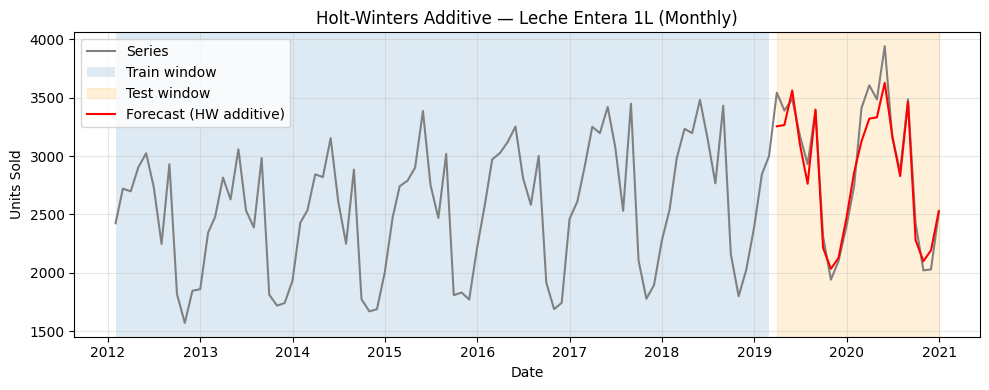

In [252]:
plt.figure(figsize=(10,4))
y_all = pd.concat([y_train_mes, y_test_mes])
plt.plot(y_all.index, y_all, color='gray', label='Series')
plt.axvspan(y_train_mes.index[0], y_train_mes.index[-1], alpha=0.15, label='Train window')
plt.axvspan(y_test_mes.index[0],  y_test_mes.index[-1],  alpha=0.15, color='orange', label='Test window')
plt.plot(y_pred_1.index,  y_pred_1,  label='Forecast (HW additive)', color='red')

plt.title('Holt-Winters Additive — Leche Entera 1L (Monthly)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Segundo Modelo basado sobre los datos en meses with the "no trend" assumption

Parámetros ajustados: {'smoothing_level': 0.30641164309988755, 'smoothing_trend': nan, 'smoothing_seasonal': 0.09849434973401025, 'damping_trend': nan, 'initial_level': 2396.3791256395107, 'initial_trend': nan, 'initial_seasons': array([   0.93988757,  252.63641351,  432.13430314,  442.64910109,
        722.35359078,  271.80234962,  -82.89620641,  546.17869272,
       -639.14356339, -822.03302588, -718.56651159, -395.42719817]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
MAE  : 164.32
RMSE : 210.73
MAPE : 5.29%


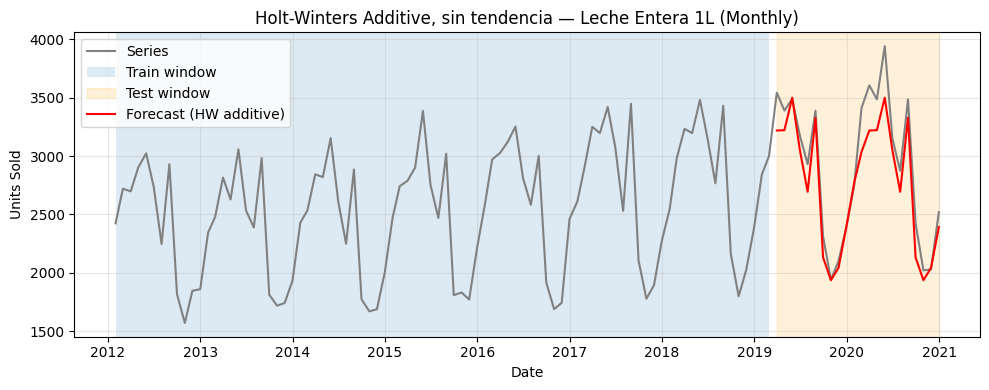

In [253]:


Model2 = ExponentialSmoothing(
    y_train_mes,
    trend=None,             # set to None if no trend
    seasonal="add",         # use "mul" if seasonality scales with level
    seasonal_periods=12
).fit(optimized=True, use_brute=True)  # brute grid first helps avoid local minima

print("Parámetros ajustados:", Model2.params)

# We generate forecast for the test period 
y_pred_2 = Model2.forecast(len(y_test_mes))
y_pred_2.index = y_test_mes.index

# We now compute errors and make a table

mae_2  = mean_absolute_error(y_test_mes, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_mes, y_pred_2))

# Avoid dividing by zero when computing MAPE
mask = y_test_mes != 0
mape_2 = np.nan
if mask.any():
    mape_2 = (np.abs((y_test_mes[mask] - y_pred_2[mask]) / y_test_mes[mask])).mean() * 100

print(f"MAE  : {mae_2:,.2f}")
print(f"RMSE : {rmse_2:,.2f}")
print(f"MAPE : {mape_2:,.2f}%")


plt.figure(figsize=(10,4))
y_all = pd.concat([y_train_mes, y_test_mes])
plt.plot(y_all.index, y_all, color='gray', label='Series')
plt.axvspan(y_train_mes.index[0], y_train_mes.index[-1], alpha=0.15, label='Train window')
plt.axvspan(y_test_mes.index[0],  y_test_mes.index[-1],  alpha=0.15, color='orange', label='Test window')
plt.plot(y_pred_2.index,  y_pred_2,  label='Forecast (HW additive)', color='red')

plt.title('Holt-Winters Additive, sin tendencia — Leche Entera 1L (Monthly)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# Tercero Modelo basado sobre los datos en semanas

Parámetros ajustados: {'smoothing_level': 0.039607489754411467, 'smoothing_trend': 0.015490364897519935, 'smoothing_seasonal': 0.01215586181622074, 'damping_trend': nan, 'initial_level': 532.1319950743166, 'initial_trend': 0.20660059452654878, 'initial_seasons': array([ -50.6836087 ,  -54.69568034,  -26.1337657 ,    3.8893464 ,
        -17.11689473,    6.46009579,   70.93942269,  113.27618723,
        119.95303812,   96.50427125,   86.75162417,   95.0452376 ,
        100.02417454,   83.52273825,   82.08649059,  137.42892357,
         72.8283789 ,  125.92167573,  129.32038982,  131.8634597 ,
        148.10950971,  172.21113158,  176.35795119,   67.11362607,
         79.20378839,   76.35646255,   48.24374404,   -2.98927059,
        -14.00626735,   -6.26295132,  -20.78489594,    4.35914677,
         79.65561145,  137.37397359,  132.61990527,   74.44504539,
       -114.86449878, -180.71104132,  -59.47509044, -154.84630679,
       -166.36357775, -189.16968283, -190.31052618, -195.33721412,


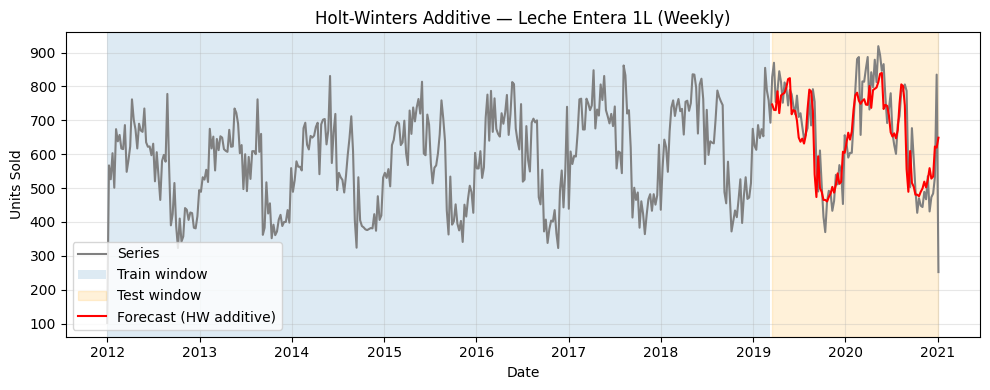

In [254]:

#We first create two new data frames that can be used by our Holt-Winters model. These dataframe are composed of only the date (by month) and the quantity attributes 

y_train_sem = ventas_train_sem.set_index("Date")["Quantity"].asfreq("W", fill_value=0)
y_test_sem  = ventas_test_sem.set_index("Date")["Quantity"].asfreq("W", fill_value=0)

Model3 = ExponentialSmoothing(
    y_train_sem,
    trend="add",             # set to None if no trend
    seasonal="add",          # use "mul" if seasonality scales with level
    seasonal_periods=52
).fit(optimized=True, use_brute=True)  # brute grid first helps avoid local minima

print("Parámetros ajustados:", Model3.params)

# We generate forecast for the test period 
y_pred_3 = Model3.forecast(len(y_test_sem))
y_pred_3.index = y_test_sem.index


mae_3  = mean_absolute_error(y_test_sem, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_sem, y_pred_3))

# Avoid dividing by zero when computing MAPE
mask = y_test_sem != 0
mape_3 = np.nan
if mask.any():
    mape_3 = (np.abs((y_test_sem[mask] - y_pred_3[mask]) / y_test_sem[mask])).mean() * 100

print(f"MAE  : {mae_3:,.2f}")
print(f"RMSE : {rmse_3:,.2f}")
print(f"MAPE : {mape_3:,.2f}%")

plt.figure(figsize=(10,4))
y_all = pd.concat([y_train_sem, y_test_sem])
plt.plot(y_all.index, y_all, color='gray', label='Series')
plt.axvspan(y_train_sem.index[0], y_train_sem.index[-1], alpha=0.15, label='Train window')
plt.axvspan(y_test_sem.index[0],  y_test_sem.index[-1],  alpha=0.15, color='orange', label='Test window')
plt.plot(y_pred_3.index,  y_pred_3,  label='Forecast (HW additive)', color='red')

plt.title('Holt-Winters Additive — Leche Entera 1L (Weekly)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# Cuatro Modelo basado sobre los datos en semanas con "no trend" assumption

Parámetros ajustados: {'smoothing_level': 0.1392999092071929, 'smoothing_trend': nan, 'smoothing_seasonal': 0.007141654716083653, 'damping_trend': nan, 'initial_level': 513.1275578851391, 'initial_trend': nan, 'initial_seasons': array([ -54.60647246,  -57.3232414 ,  -27.49137455,    2.94577183,
        -17.15086455,    6.30975891,   70.32481348,  113.01807072,
        121.52639987,   97.31178924,   88.71725088,   95.98368169,
        100.13306112,   87.42375677,   89.97573595,  144.03845973,
         78.84893885,  122.54466355,  128.92688954,  138.39925789,
        149.5702841 ,  174.6746571 ,  162.01674922,   74.16793165,
         84.66492762,   79.55680804,   49.59910043,    5.29574636,
        -19.10477163,   -0.64794966,  -18.33703378,   -1.43771686,
         88.59339339,  141.29780482,  130.34765448,   80.68792403,
        -98.52841978, -178.88865395,  -68.29287351, -155.24179485,
       -167.96202255, -201.65457471, -195.96353954, -199.76590364,
       -192.51627332, -178.2553304

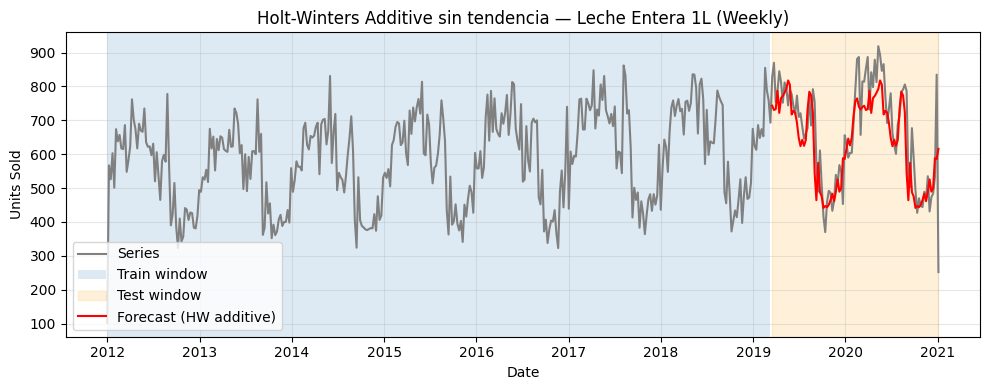

In [255]:
# We first create two new data frames that can be used by our Holt-Winters model.
Model3 = ExponentialSmoothing(
    y_train_sem,
    trend=None,             # set to None if no trend
    seasonal="add",          # use "mul" if seasonality scales with level
    seasonal_periods=52
).fit(optimized=True, use_brute=True)  # brute grid first helps avoid local minima

print("Parámetros ajustados:", Model3.params)

# We generate forecast for the test period 
y_pred_4 = Model3.forecast(len(y_test_sem))
y_pred_4.index = y_test_sem.index

# pip install scikit-learn
mae_4  = mean_absolute_error(y_test_sem, y_pred_4)
rmse_4 = np.sqrt(mean_squared_error(y_test_sem, y_pred_4))

# Avoid dividing by zero when computing MAPE
mask = y_test_sem != 0
mape_4 = np.nan
if mask.any():
    mape_4 = (np.abs((y_test_sem[mask] - y_pred_4[mask]) / y_test_sem[mask])).mean() * 100

print(f"MAE  : {mae_4:,.2f}")
print(f"RMSE : {rmse_4:,.2f}")
print(f"MAPE : {mape_4:,.2f}%")


plt.figure(figsize=(10,4))
y_all = pd.concat([y_train_sem, y_test_sem])
plt.plot(y_all.index, y_all, color='gray', label='Series')
plt.axvspan(y_train_sem.index[0], y_train_sem.index[-1], alpha=0.15, label='Train window')
plt.axvspan(y_test_sem.index[0],  y_test_sem.index[-1],  alpha=0.15, color='orange', label='Test window')
plt.plot(y_pred_4.index,  y_pred_4,  label='Forecast (HW additive)', color='red')

plt.title('Holt-Winters Additive sin tendencia — Leche Entera 1L (Weekly)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Pregunta 3.3

3. Evaluación Cuantitativa (8 Puntos):
• Genere un pronóstico para el período que cubre el conjunto de prueba.
• Calcule al menos tres métricas de error (ej. MSE, MAE, RMSE, MAPE) para su
modelo. Presente los resultados en una tabla y comente sobre el rendimiento

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/646496130.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.07%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Result_rounded.loc['MAPE'] = Result_rounded.loc['MAPE'].astype(str) + '%'
/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/646496130.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.29%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Result_rounded.loc['MAPE'] = Result_rounded.loc['MAPE'].astype(str) + '%'
/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_12880/646496130.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.77%' has dtype incompat

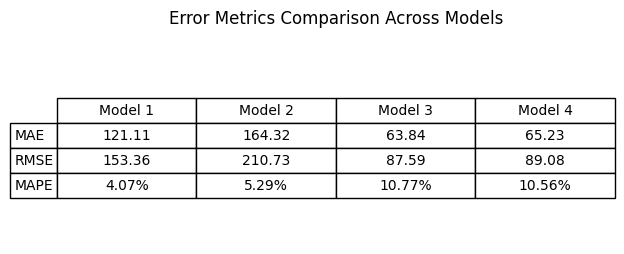

In [256]:
Result_errors= pd.DataFrame({
    'Model 1': [mae_1, rmse_1, mape_1],
    'Model 2': [mae_2, rmse_2, mape_2,],
    'Model 3': [mae_3,  rmse_3, mape_3],
    'Model 4': [mae_4, rmse_4, mape_4]
}, index=['MAE', 'RMSE', 'MAPE'])

Result_rounded= Result_errors.round(2)
Result_rounded.loc['MAPE'] = Result_rounded.loc['MAPE'].astype(str) + '%'

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis('off')  # Hide axes

table = ax.table(
    cellText=Result_rounded.values,
    rowLabels=Result_rounded.index,
    colLabels=Result_rounded.columns,
    cellLoc='center',
    loc='center'
)
table.scale(1.2, 1.5)  # make table bigger
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('Error Metrics Comparison Across Models', pad=20)
plt.show()